In [1]:
import torch
import numpy as np
from torch import optim
import os
import matplotlib.pyplot as plt
import seaborn

In [2]:
from datareader import DLEMDataset
from models.encodetocontact_forked import DLEM
import util

In [3]:
def return_pred_diag(model, patchs, tracks):
    patchs = torch.from_numpy(patchs)
    tracks = torch.from_numpy(tracks)
    init_diag = torch.from_numpy(np.ones((tracks.shape[0], tracks.shape[2]), dtype=np.float32))
    return model.contact_map_prediction(tracks, init_diag)

In [4]:
def return_pred_param(model, patch, tracks):
    patch = torch.from_numpy(patch)
    tracks = torch.from_numpy(tracks)
    init_diag = torch.from_numpy(np.ones((tracks.shape[0], tracks.shape[2]), dtype=np.float32))
    def convert_diags(diags):
        return util.convert_diags_to_full_contact(
                    diags,
                    model.start_diag,
                    model.stop_diag
               )

    preds = model.contact_map_prediction(tracks, init_diag)
    preds = [convert_diags(p) for p in preds]

    p_l, p_r = model.return_parameters(tracks)
    return preds, p_l, p_r


In [5]:
BATCH_SIZE = 64
#DATA_FOLDER = ".data/dlem_training"
DATA_FOLDER = "../loopextrusion_data_creation/.data/training_data_res_1000_patch_size_500"
TEST_FOLD = 'fold4'
VAL_FOLD = 'fold5'
LEARNING_RATE = 0.001
PATIENCE = 200
NUM_EPOCH = 100
NUMBER_OF_CHANNELS_PER_ROUTE = 3
MODEL_FOLDER = f"{NUMBER_OF_CHANNELS_PER_ROUTE}_per_route_res_1000"

In [6]:
dev = torch.device("cpu")

In [7]:
data = DLEMDataset(DATA_FOLDER)

data_test = torch.utils.data.Subset(data, np.where(data.data_folds == TEST_FOLD)[0])

In [8]:
data.stop_diag

400

In [9]:
model = DLEM(data.patch_dim,
             data.feature_dim,
             data.start_diag,
             data.stop_diag,
             channel_per_route=NUMBER_OF_CHANNELS_PER_ROUTE)
model.load_state_dict(
         torch.load(os.path.join(DATA_FOLDER, MODEL_FOLDER, "best_correlation.pt"))
)
model = model.to(dev).eval()

In [10]:
model

DLEM(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(4, 12, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(9, 9, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(6, 6, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (trans_convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (mixer): Sequential(
    (0): Conv1d(12, 2, kernel_size=(1,), stride=(1,))
    (1): Sigmoid()
  )
)

In [11]:
def plot_one_sample(patch, pred, p_l, p_r, scale, axes):
    util.plot_results(patch, pred,
                (p_l, p_r, np.ones_like(p_l)),
                ignore_i=data.start_diag, ignore_i_off=data.stop_diag,
                cmap="vlag", scale=scale, axes=axes)

def plot_multiple_samples(nrows, ncols, samples, model, scale=0.4):
    preds, p_l, p_r = return_pred_param(model, samples[0], samples[1])
    patch_mat = [util.convert_diags_to_full_contact(patch, model.start_diag, model.stop_diag) for patch in samples[0]]
    _, axes = plt.subplots(nrows=2*nrows, ncols=2*ncols, figsize=(ncols*12*scale, nrows*12*scale),
                                sharex='col',
                                sharey='row',
                                gridspec_kw={'wspace':0,
                                            'hspace':0,
                                            'height_ratios':[1, 5] * nrows,
                                            'width_ratios':[5, 1] * ncols})
    i = 0
    for r in range(nrows):
        for c in range(ncols):
            plot_one_sample(patch_mat[i], preds[i], p_l[i], p_r[i], scale, axes[2*r:2*(r+1), 2*c:2*(c+1)])
            i += 1

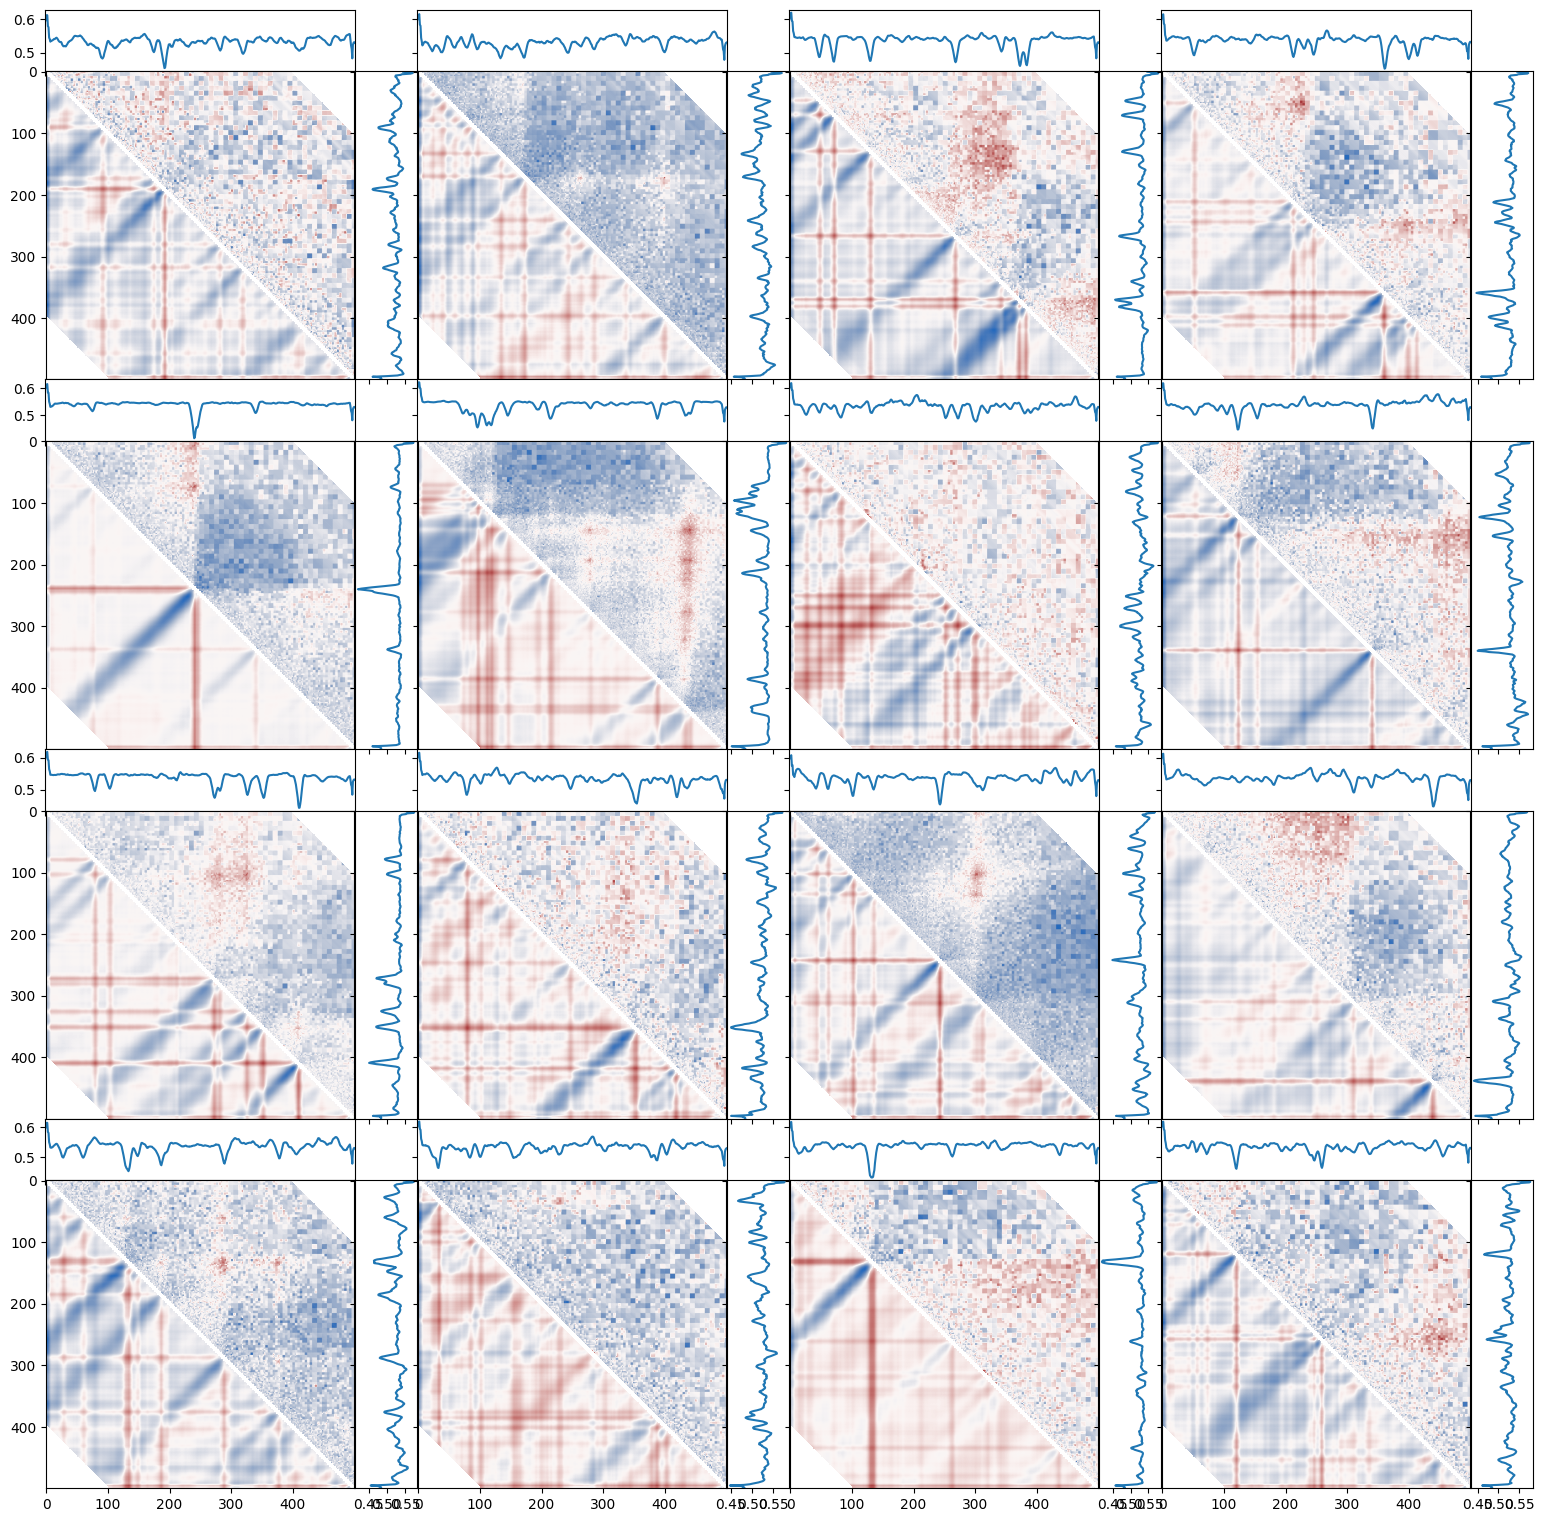

In [12]:
plot_multiple_samples(4,4,data_test[np.random.choice(range(len(data_test)), 16)], model)

Cherry picking

In [13]:
corrs = []
for i in range(len(data_test)//10):
    pred = return_pred_diag(model, data_test[i*10:(i+1)*10][0], data_test[i*10:(i+1)*10][1])
    corrs.append(np.diag(np.corrcoef(data_test[i*10:(i+1)*10][0],pred.detach().cpu().numpy())[:10,10:]))

In [14]:
corrs = np.concatenate(corrs)

In [15]:
np.mean(corrs)

0.14918997219779406

In [16]:
corrs[np.argsort(-corrs)[:16]]

array([0.44145141, 0.42153464, 0.41534806, 0.40947934, 0.40625933,
       0.40416773, 0.40362216, 0.4014732 , 0.39942162, 0.39709006,
       0.39506014, 0.39269052, 0.39082479, 0.38400508, 0.38185162,
       0.38141491])

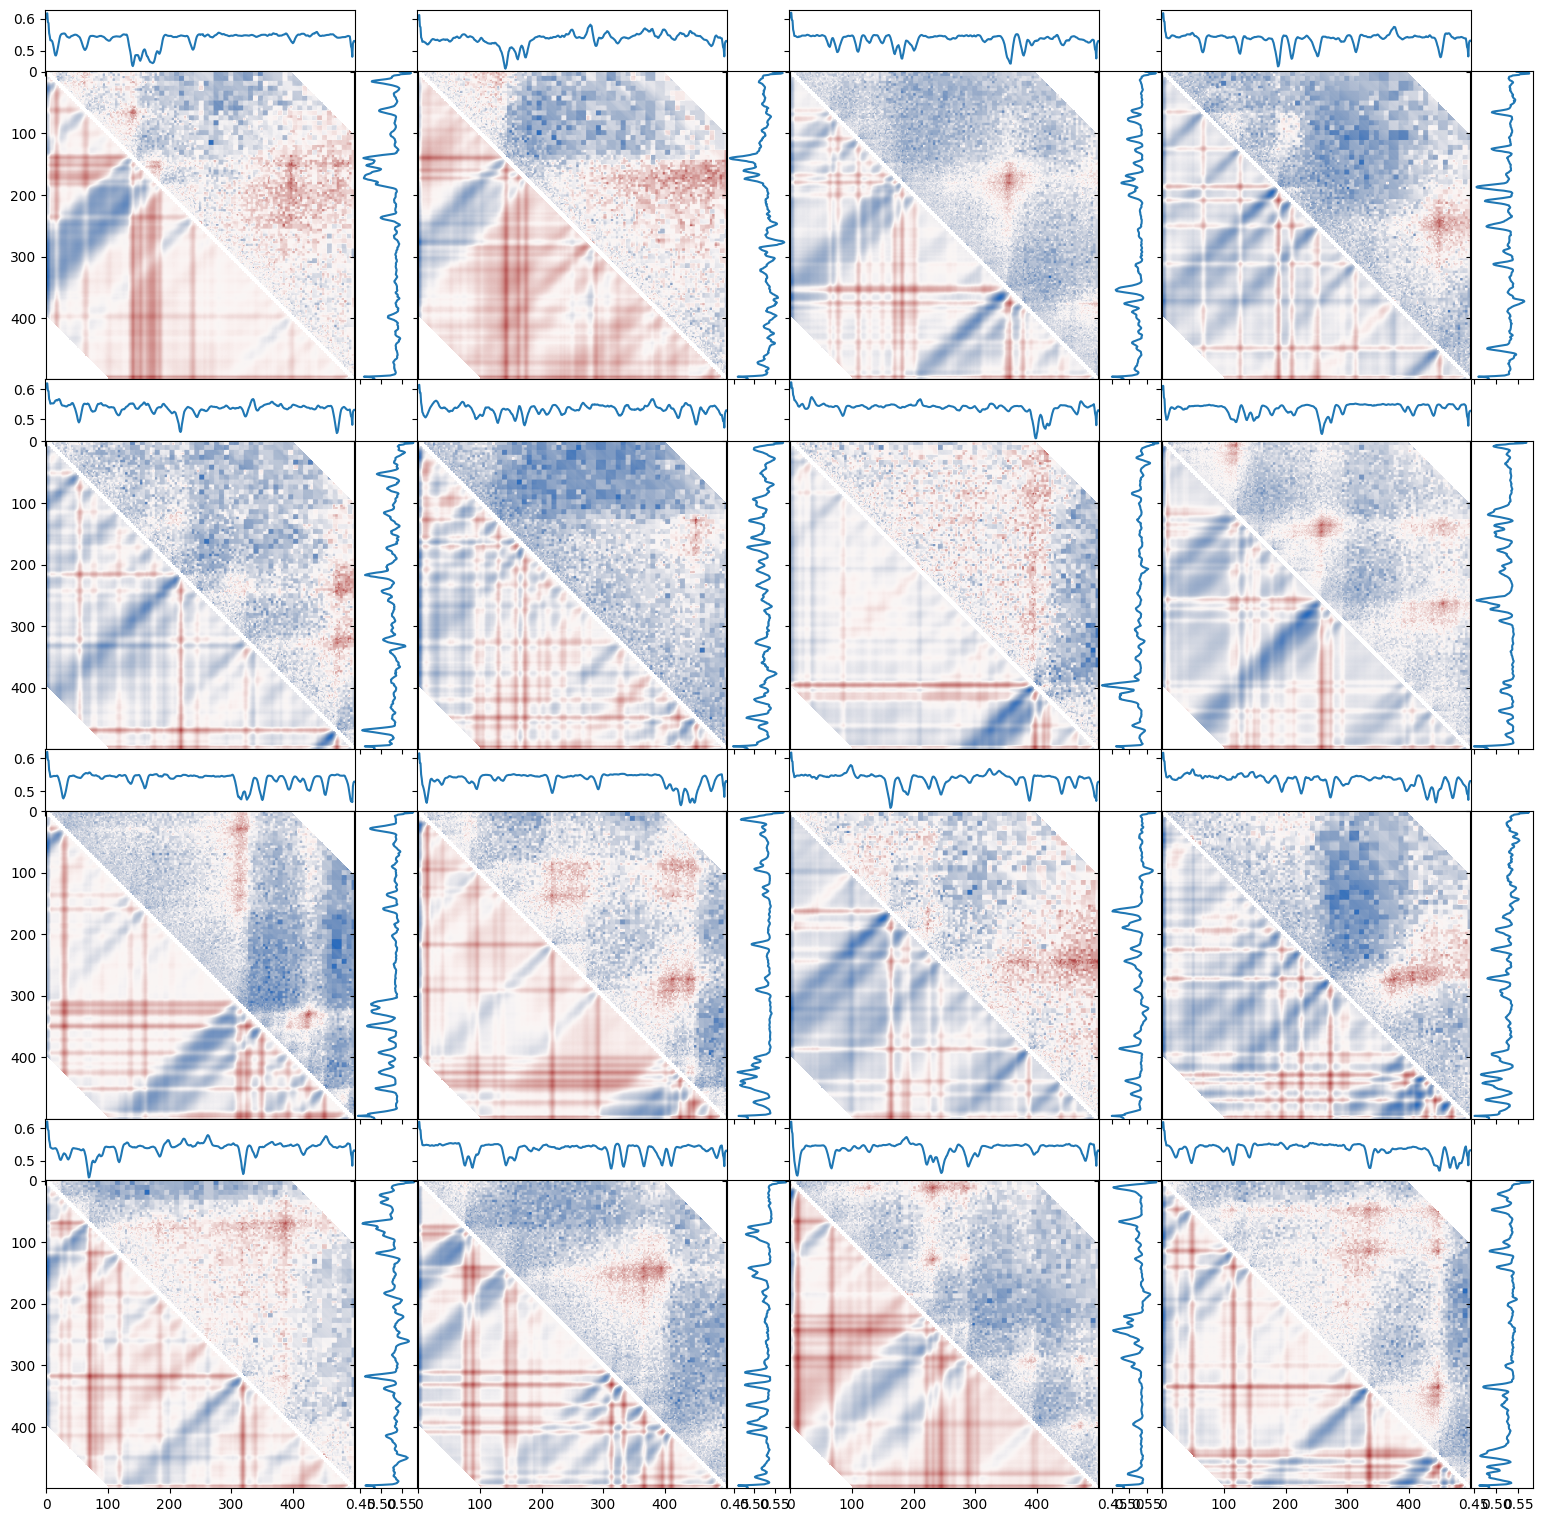

In [17]:
plot_multiple_samples(4,4,data_test[np.argsort(-corrs)[:16]], model)

In [18]:
corrs[np.argsort(corrs)[:16]]

array([-0.17094757, -0.16973744, -0.140779  , -0.12489148, -0.11836164,
       -0.11414207, -0.10961568, -0.10259344, -0.08537083, -0.07936102,
       -0.07654823, -0.07418184, -0.07158163, -0.06034973, -0.05924631,
       -0.05605932])

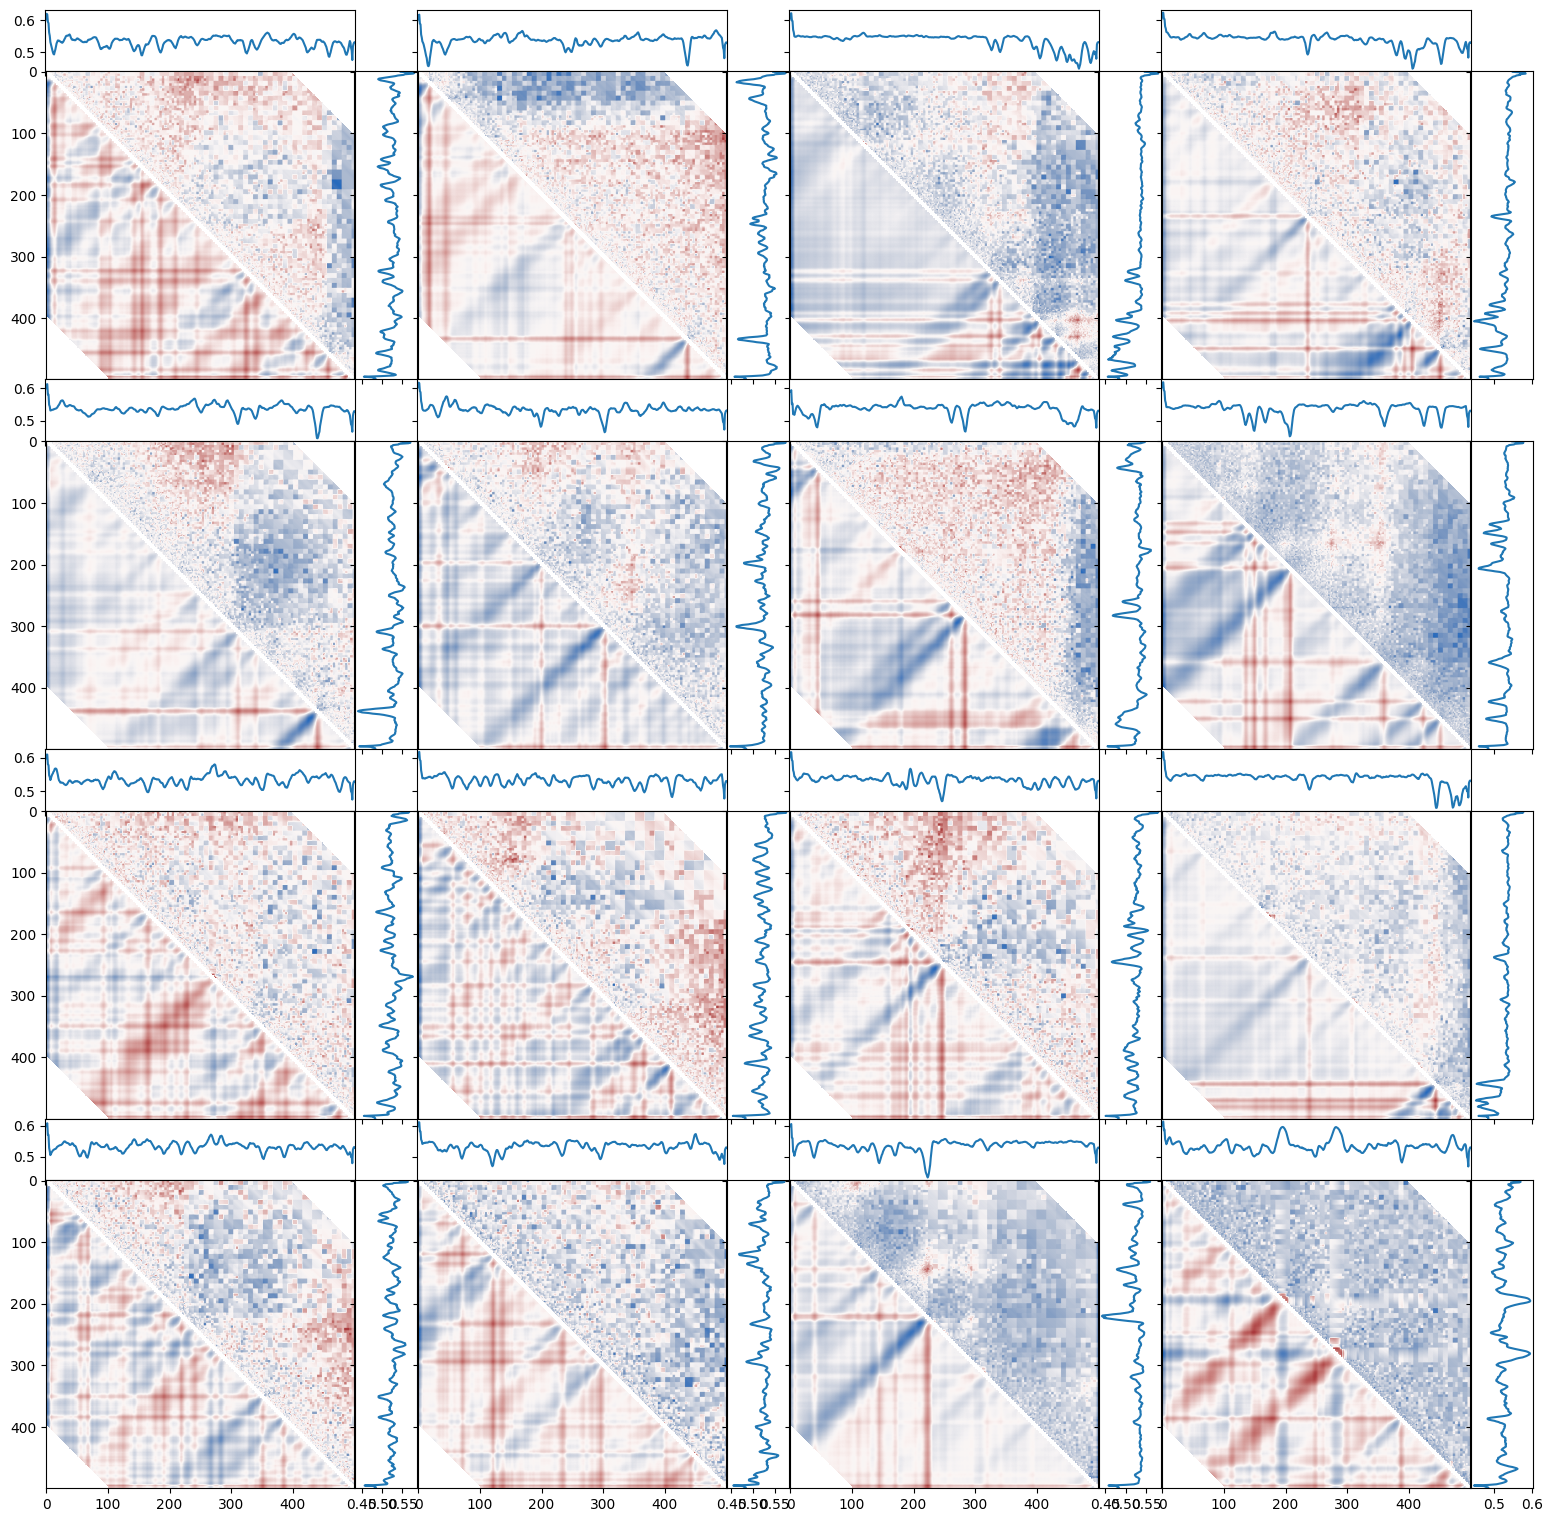

In [19]:
plot_multiple_samples(4,4,data_test[np.argsort(corrs)[:16]], model)